In [114]:
import cv2
import numpy as np
import face_recognition
from matplotlib import pyplot as plt

image_name = "test_face.png"

image = cv2.imread(image_name)

# Load the jpg file into a numpy array
face_rec = face_recognition.load_image_file(image_name)

face_locations = face_recognition.face_locations(face_rec, model="hog")

# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(face_rec, model="large")

print(face_landmarks_list)


[{'chin': [(467, 221), (469, 251), (474, 280), (481, 308), (494, 334), (513, 354), (536, 371), (561, 382), (587, 384), (613, 377), (636, 360), (656, 341), (671, 317), (680, 289), (682, 260), (682, 229), (681, 198)], 'left_eyebrow': [(479, 179), (491, 165), (510, 158), (529, 158), (549, 164)], 'right_eyebrow': [(588, 162), (606, 154), (626, 150), (645, 155), (660, 168)], 'nose_bridge': [(570, 196), (571, 217), (572, 237), (573, 257)], 'nose_tip': [(553, 275), (564, 277), (575, 279), (586, 275), (597, 272)], 'left_eye': [(499, 204), (511, 194), (526, 195), (539, 206), (525, 209), (510, 209)], 'right_eye': [(602, 203), (614, 189), (629, 188), (643, 196), (632, 202), (616, 204)], 'top_lip': [(535, 316), (549, 301), (565, 294), (578, 296), (590, 293), (608, 298), (625, 308), (621, 308), (590, 304), (578, 305), (566, 305), (540, 314)], 'bottom_lip': [(625, 308), (611, 328), (594, 337), (581, 339), (567, 338), (551, 332), (535, 316), (540, 314), (567, 325), (579, 326), (592, 324), (621, 308)]

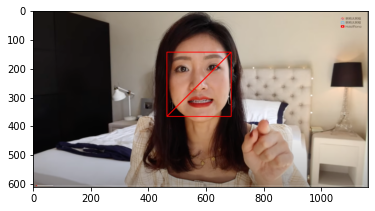

In [108]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for face_location in face_locations:
    rect_top_right = (face_location[1], face_location[0])
    rect_bottom_left = (face_location[3], face_location[2])
    cv2.rectangle(image_rgb, rect_top_right, rect_bottom_left, (255, 0, 0), 2)
    cv2.line(image_rgb, rect_top_right, rect_bottom_left, (255, 0, 0), 2)

plt.imshow(image_rgb)

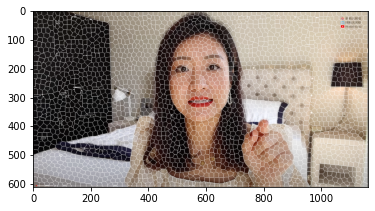

In [117]:
from cv2.ximgproc import createSuperpixelSLIC, SLICO

image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

cv_slic = createSuperpixelSLIC(image_lab, algorithm=SLICO, region_size=16)
cv_slic.iterate(num_iterations=30)

contour_mask = cv_slic.getLabelContourMask(thick_line=True)

image_with_contours = image.copy()
contour_locations = cv2.findNonZero(contour_mask)
for contour_location in contour_locations:
    image_with_contours[contour_location[0][1], contour_location[0][0]] = (255, 255, 255)

plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))

230
608 [11 11 24] [  0 138  24] [ 15 134 126]
609 [13 13 26] [  0 127  26] [ 17 134 126]
610 [19 23 50] [  4 158  50] [ 31 142 121]
611 [ 74  98 150] [  9 129 150] [111 156 107]
612 [100 127 181] [ 10 114 181] [140 157 105]
613 [114 140 195] [ 10 106 195] [153 158 106]
616 [129 150 201] [  9  91 201] [163 155 109]
619 [144 159 198] [  8  70 198] [169 149 114]
620 [152 163 199] [  7  60 199] [173 147 116]
621 [ 78  88 115] [  8  82 115] [ 95 142 118]
622 [21 22 29] [ 4 70 29] [ 24 132 126]
681 [13 13 27] [  0 132  27] [ 17 135 126]
682 [17 20 45] [  3 159  45] [ 27 141 122]
683 [ 65  88 136] [ 10 133 136] [100 154 108]
684 [108 132 181] [ 10 103 181] [144 154 108]
685 [115 141 192] [ 10 102 192] [153 156 107]
686 [130 153 204] [  9  93 204] [166 155 108]
687 [139 159 208] [  9  85 208] [171 154 110]
688 [140 159 208] [  8  83 208] [171 154 111]
689 [139 157 204] [  8  81 204] [169 153 111]
690 [142 158 201] [  8  75 201] [169 151 113]
691 [ 86 104 139] [ 10  97 139] [112 147 113]
692 [

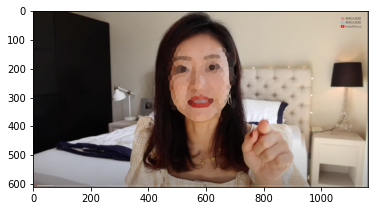

In [118]:
labels = cv_slic.getLabels()

image_slic = image.copy()
valid_superpixel_locations = []
for i in range(cv_slic.getNumberOfSuperpixels()):
    superpixel_location = np.where(labels == i)
    superpixel_in_face = False
    for x, y in zip(superpixel_location[1], superpixel_location[0]):
        for face_location in face_locations:
            rect_top_right = (face_location[1], face_location[0])
            rect_bottom_left = (face_location[3], face_location[2])
            if (x >= rect_bottom_left[0] and x <= rect_top_right[0]) and (y >= rect_top_right[1] and y <= rect_bottom_left[1]):
                superpixel_in_face = True
                valid_superpixel_locations.append((i, superpixel_location))
                break
        if superpixel_in_face:
            break

print(len(valid_superpixel_locations))
for label, superpixel_location in valid_superpixel_locations:
    pixels = np.zeros((superpixel_location[0].shape[0], 3), dtype=np.uint8)
    j = 0
    for x, y in zip(superpixel_location[1], superpixel_location[0]):
        pixels[j] = image_slic[y, x]
        j += 1
    mean_color = np.mean(pixels, axis=0).astype(np.uint8)
    color = np.zeros((1, 1, 3), dtype=np.uint8)
    color[0][0] = mean_color
    print(label, mean_color, cv2.cvtColor(color, cv2.COLOR_BGR2HSV)[0][0], cv2.cvtColor(color, cv2.COLOR_BGR2YCrCb)[0][0])
    for x, y in zip(superpixel_location[1], superpixel_location[0]):
        image_slic[y, x] = mean_color

plt.imshow(cv2.cvtColor(image_slic, cv2.COLOR_BGR2RGB))

In [111]:
image_hsv = cv2.cvtColor(image_slic, cv2.COLOR_BGR2HSV)
image_y_cr_cb = cv2.cvtColor(image_slic, cv2.COLOR_BGR2YCrCb)

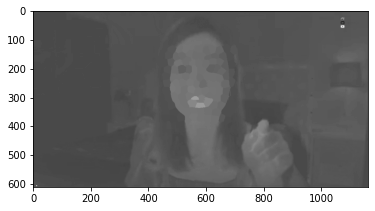

In [112]:
plt.imshow(image_y_cr_cb[:, :, 1], cmap="gray")

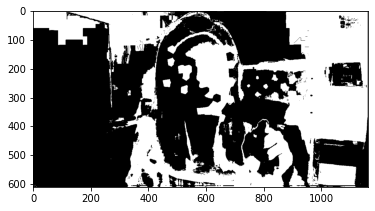

In [113]:
lower_hsv_values = np.array([6, 40, 0], dtype = "uint8")
upper_hsv_values = np.array([25, 100, 255], dtype = "uint8")

lower_y_cr_cb_values = np.array((0, 138, 67), dtype = "uint8")
upper_y_cr_cb_values = np.array((255, 150, 133), dtype = "uint8")

#A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
mask_y_cr_cb = cv2.inRange(image_y_cr_cb, lower_y_cr_cb_values, upper_y_cr_cb_values)
mask_hsv = cv2.inRange(image_hsv, lower_hsv_values, upper_hsv_values)

mask_skin_tone = cv2.add(mask_hsv, mask_y_cr_cb)

plt.imshow(mask_skin_tone, cmap='gray')